In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ZTF matchfiles to SDSS : offsets 

### Connect to Spark 

In [10]:
import pyspark
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from astropy.table import Table 
spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
    
    

In [11]:
spark

show tables available in the AXS Catalog 

In [12]:
spark.catalog.listTables()

[Table(name='_gatspy_ztf2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='allwise_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='demo_result', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='gaia_dr2_700lc_new', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_ebv', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_sfd', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_sdss_3asec', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_sdss_w

Load the ZTF matchfiles cross-matched to SDSS . Specifically,  SDSS catalog was limited to bright stars 

    limitMag = 20 
    sdss_sel = sdss.select(['zone', 'RA', 'DEC', 'u','g','r','i',
                        'uErr','gErr', 'rErr', 'iErr', 'dup']).\
    where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
    ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag))
    
    
and ZTF matchfiles (`ztf_1am_lc`) was split into rows corresponding to filter 1 or filter 2 (fid),  requiring over 10 good observations  : 

    fid = 2  # 1 
    ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], fid)))
      
and the two were crossmatched with 2 arcsec matching radius : 

    crossmatch = ztf_lc_fid.crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
    save_axs_table(fname)
        


In [14]:


axs_catalog = AxsCatalog(spark)
s1 = axs_catalog.load("ztf_fid1_sdss_stars_lt20_2asec")  # ZTFg 
s2 = axs_catalog.load("ztf_fid2_sdss_stars_lt20_2asec")  # ZTFr 
s3 = axs_catalog.load("ztf_fid3_sdss_stars_lt20_2asec")  # ZTFi

In [17]:
for f,s in zip('gri', [s1,s2,s3]):
    print('For ZTF ', f ,'-SDSS crossmatch (SDSS g<20 mag) there are ', s.count(), ' stars')

For ZTF  g -SDSS crossmatch (r<20 mag) there are  14271730  stars
For ZTF  r -SDSS crossmatch (r<20 mag) there are  24735832  stars
For ZTF  i -SDSS crossmatch (r<20 mag) there are  1017499  stars


In [11]:
# easier to see all columns if we convert to Pandas ....

pd.options.display.max_columns = 999
s1.limit(10).toPandas()

,zone,dup,matchid,bestmagrms,bestmeanmag,bestmedianmag,medianmag,meanmag,nbestobs,ngoodobs,u,g,r,i,uErr,gErr,rErr,iErr,axsdist,ra,dec
0,6589,0,00057912031122,0.186448,19.750542,19.818748,19.813808,19.753742,12,13,2.176900,11.446885,22.849567,30.775221,12.208536,12.463176,7.163517,3.454204,4.461773e-07,205.085932,19.828893
1,6589,0,000579120310272,0.029949,17.244308,17.249290,17.245487,17.236458,25,32,20.169413,115.192566,227.870697,284.796539,2.860005,0.161344,0.108076,0.060292,6.985763e-07,205.229231,19.829647
2,6589,0,000579120310271,0.051145,18.381041,18.379879,18.379879,18.376999,24,30,17.708698,42.649181,53.779533,60.433449,2.238559,1.010788,2.300889,1.593961,5.306675e-07,205.296017,19.831281
3,6589,0,000579120310269,0.027903,17.761429,17.760418,17.759117,17.749771,25,32,25.141823,74.539207,112.440300,134.570770,1.328979,0.338333,0.589831,0.374766,1.062936e-07,205.301593,19.831889
4,6589,0,0005791203104482,0.096673,19.027988,19.043140,19.043140,19.028290,25,29,6.604302,23.761436,37.633652,47.289928,4.175580,3.075281,4.196288,2.368500,6.495113e-07,205.325148,19.823975
5,6589,0,000579120310293,0.106185,19.353924,19.379879,19.373978,19.341578,22,26,2.118989,15.918954,46.175308,68.423141,11.289819,8.273084,1.432515,0.849621,5.527387e-07,205.621056,19.831809
6,6589,0,000579120310343,0.119455,19.113150,19.123951,19.123951,19.114773,25,29,10.161666,21.585836,28.635065,32.186237,5.353713,4.834577,3.370195,2.974591,1.663153e-07,205.669341,19.820592
7,6589,0,000579120310313,0.024945,17.465590,17.464788,17.462101,17.455614,25,32,44.570713,100.447197,135.654358,149.536041,1.061037,0.228686,0.361069,0.131258,3.970325e-07,205.814072,19.829835
8,6589,0,000579120310327,0.046096,18.275084,18.275148,18.270142,18.266367,24,30,13.302402,47.536205,81.400528,98.492340,5.432729,1.386383,0.747526,0.426089,1.504680e-06,205.917063,19.829288
9,6589,0,000579120310327,0.046096,18.275084,18.275148,18.270142,18.266367,24,30,12.449090,47.217457,79.161507,97.047928,5.785248,1.585820,1.435358,0.455477,1.452136e-06,205.917063,19.829288


In [18]:
import pandas as pd
from astropy.table import Table 

Make a function to find offset between ZTF and SDSS using cross-matched stars.  

In [64]:
def find_offset_sdss_survey(axs_catalog, originband = 'g',
                            targetband = 'r', sdsscolors = 'gi',
                            magCol = 'bestmedianmag', errCol = 'bestmagrms',
                            survey = 'ZTF', degree = 1 , xlims = [-0.5,2.5],
                            ylims = [-0.2, 1.5], nsources = 10000,
                            xfitlims = [0.25, 1.5]) :
    '''
    Find photometric offsets between SDSS and a survey, like
    ZTF, one band at a time. 
   
    data :  a table containing ugri SDSS photometry, cross-matched to 
            the target survey, eg. SDSS-ZTF
           
    originband : band present in the origin survey. Eg., 
               for ZTF it's 'g', 'r' or 'i'
               
    targetband : synthetic SDSS band to which we transform the ZTF band, 
               eg. 'r'.  One could have ZTF(gri) --> SDSS(rrr),  
               or  ZTF(gri) --> SDSS(gri)   , depending on the need 
    
    sdsscolors : SDSS colors used to spread the stellar locus.  It can be 
           "gr" or "gi" (this mainly affects the x-axis limits). 
           'gi' is preferred as default because it provides a larger
            wavelength baseline 
           
    magCol : the name of column in 'data' that contains the 
            survey magnitudes
    
    errCol : the name of column in 'data' that contains the 
            survey magnitude error
            
    survey : the name of the survey . Here by default it is 'ZTF' 
    
    degreee : the degree of fitted polynomial to derive photometric 
            offsets.  '1' is the default. The fitted polynomial 
            is overplotted with a red line over the stellar locus. 
            The fitted points are weighted by their errors. 
            
    xlims : limits on the x-axis in magnitudes (depends on the 
          SDSS color chosen for the x-axis). By default, [-0.5,2.5]
         
    ylims : limits on the y-axis in magnitudes (depends on 
        the origin and target bands and relative offsets). 
        By default,  [-0.2, 1.5]
        
    nsources: how many sources to take from the input spark tables?  
         The default is 10000, which is enough to quickly execute, 
         see the stellar locus, fine-tune the parameters of fit, 
         xlims, ylims of the plot, etc. 
         More may be desired for better statistics,  but it has to be 
         less than the total length of the table (!)
    xFITlims : the limits along x-axis (SDSS color) for points used for the 
         polynomial fit. By default,  for (g-i) its [0.25, 1.5] and for 
         (g-r) its [0.1, 1.1]
    '''
    
    # convert the axs_catalog given to Pandas dataframe 
    data = axs_catalog.select(['bestmedianmag', 'bestmagrms', 'u','g','r','i', 
                 'uErr', 'gErr', 'rErr', 'iErr']).\
    limit(nsources).toPandas()
    
    
    # convert SDSS fluxes to mags 
    for f in 'ugri' : 
        # SDSS data ...  convert to mags 
        data[f+'Mag'] = -2.5 * np.log10(data[f]) + 22.5

        # convert errors  on flux to errors on mag 
        data[f+'MagErr'] = (5.0 / (2*np.log(10))) * data[f+'Err'] / data[f]
    
    # define aliases for SDSS mags  
    gmag = data['gMag']
    rmag = data['rMag']
    imag = data['iMag']


    #xaxis : SDSS color  - 'gi' or 'gr'
    if sdsscolors is 'gr': 
        x =  gmag-rmag 

    if sdsscolors is 'gi' : 
        x = gmag-imag  
        
    # create the plotting space 
    fig,axs = plt.subplots(1,1, figsize=(5, 4.8))
    ax = np.ravel(axs)
    i = 0 

    # make a table to store coefficients derived from this set of data 
    if degree == 1 : 
        coeffs  = {'x' : [], 'y' : [], 'B_0' : [], 'B_1':[]}

    if degree == 2 : 
        coeffs  = {'x' : [], 'y' : [], 'A_0' : [], 'A_1':[],'A_2':[]}

     # no need to loop since we're doing one filter at a time 
    # the SDSS target is 'r' only . since that's the "master band"
    f1,f2  = originband, targetband
    print(' ')
    print('y = f1 - f2 = f(x)')
    print('f2 = f1 - f(x)')

    # store filters used 
    coeffs['x'].append('('+sdsscolors[0]+'-'+sdsscolors[1]+')_SDSS')
    coeffs['y'].append(f1 +survey+'-'+f2+'SDSS')



    # remove objects without ZTF obs ...
    print('Starting with ', len(data), ' objects ')
    m1 = data[magCol] > 0 
    print('\nRemoving objects without ', magCol, '>0')
    print('= Left with ', np.sum(m1), ' objects')


    surveyMag = data[magCol]
    sdssMag  = data[f2 + 'Mag']

    y  = surveyMag - sdssMag


    # combine errors in quadrature to use as weights in 
    # fitting with polynomial 
    e1 = data[errCol] # Survey error on the Mean 
    e2 = data[f2+'MagErr']  # SDSS standard error for the mean

    # remove stars that have no obs in that filter 
    ax[i].hexbin(x[m1],y[m1], extent= (xlims[0],xlims[1], 
                                       ylims[0], ylims[1]), bins='log'
                     )

    
    # make the linear fits 
    m2 = (xfitlims[0]<x) & (x<xfitlims[1]) # within the xlims of the fit 
    m3 = (ylims[0] < y) & (y < ylims[1]) # within the ylims of the plot 
    m4 = np.bitwise_not(np.isnan(e1)) # points that do not have the error for ZTF 
    m_ = m1 & m2 & m3 & m4
    
    
    print('\nOf these we do not use for fitting those  beyond the limits of the \
    plot, or xlims of fitted region.')
    print('=Left with ', np.sum(m_),' objects used for fitting')
    

    # fit n-th degree polynomial
    xf  = x[m_] ;  yf=y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)

    p = np.polyfit(xf,yf,deg=degree)#, w=1/ef)

    if degree == 1 : 
        # like  y = B_0 + B_1 * x as  in Tonry+2012 
        coeffs['B_1'].append(p[0]) 
        coeffs['B_0'].append(p[1])  
        x_ = np.linspace(xfitlims[0],xfitlims[1], 100)
        ax[i].plot(x_, p[0] *x_ + p[1]  , c='red')
        print('y = f(x) = B0 + B1*x')
        print('')
        
        
        print(f2,'_SDSS_synth =', f1,'_', survey,'- (', str(coeffs['B_0'][0])[:5],
             ')-(',str(coeffs['B_1'][0])[:5],')*','SDSS', 
              '(',sdsscolors[0],'-',sdsscolors[1],')')
        print('')

    if degree == 2 : 
        # like  y = A_0 + A_1 * x  + A_2*x*x in Tonry+2012 
        coeffs['A_2'].append(p[0]) 
        coeffs['A_1'].append(p[1]) 
        coeffs['A_0'].append(p[2])
        x_ = np.linspace(xfitlims[0],xfitlims[1], 100)
        ax[i].plot(x_, p[0] *x_*x_ + p[1] *x_ + p[2] , c='red')
        print('y = f(x) = A0 + A1*x + A2*x*x')


    # add axis labels ... 
    ax[i].set_xlabel('('+sdsscolors[0]+'-'+sdsscolors[1]+') SDSS ', 
                 fontsize=17)
    ax[i].set_ylabel(survey+'('+f1+')'+'-SDSS ('+f2+')', fontsize=17, rotation=90)


    # Save the figure ... 

    #fig.suptitle(suptitle, fontsize=18)
    figtitle = 'Offsets_'+survey+f1+'-SDSS'+f2+'_SDSS'+sdsscolors+'.png'
    print('Figure saved as ', figtitle)


    plt.savefig(figtitle,
               bbox_inches='tight')

    c  = Table(coeffs)
    print(c)
    tabtitle = 'Offsets_'+survey+f1+'-SDSS'+f2+'_SDSS'+sdsscolors+'.txt'
    c.write(tabtitle, format='ascii', overwrite='True')
    print('Coefficients stored as an ascii table ', tabtitle)

We use SDSS mean g-i color to spread the stellar locus because it provides larger wavelength baseline than g-r

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10
/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log10


 
y = f1 - f2 = f(x)
f2 = f1 - f(x)
Starting with  100000  objects 

Removing objects without  bestmedianmag >0
= Left with  97060  objects

Of these we do not use for fitting those  beyond the limits of the     plot, or xlims of fitted region.
=Left with  70258  objects used for fitting
y = f(x) = B0 + B1*x

r _SDSS_synth = g _ ZTF - ( 0.051 )-( 0.609 )* SDSS ( g - i )

Figure saved as  Offsets_ZTFg-SDSSr_SDSSgi.png
    x          y              B_0                B_1       
---------- ---------- ------------------- -----------------
(g-i)_SDSS gZTF-rSDSS 0.05115357218300919 0.609029734973498
Coefficients stored as an ascii table  Offsets_ZTFg-SDSSr_SDSSgi.txt
 
y = f1 - f2 = f(x)
f2 = f1 - f(x)
Starting with  100000  objects 

Removing objects without  bestmedianmag >0
= Left with  94285  objects

Of these we do not use for fitting those  beyond the limits of the     plot, or xlims of fitted region.
=Left with  66226  objects used for fitting
y = f(x) = B0 + B1*x

r _SDSS_synth = r _

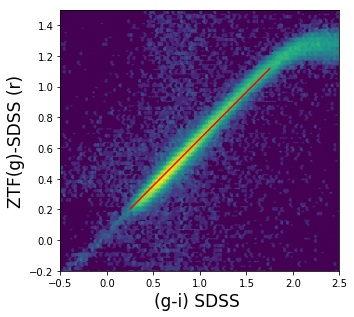

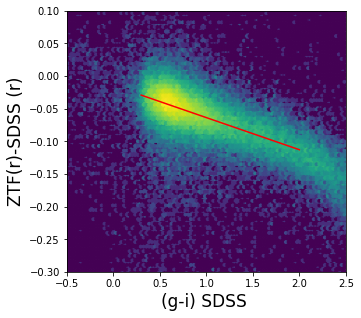

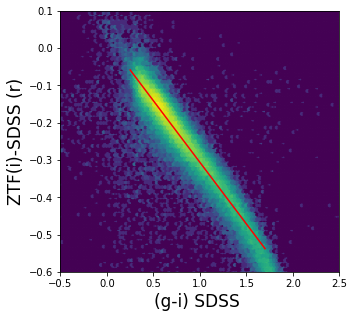

In [67]:
# find offsets from ZTF  gri to  SDSS r  
for catalog, band, ylims, xfitlims in zip([s1,s2,s3], 'gri' ,  
                                          [[-0.2, 1.5],[-0.3,0.1],[-0.6, 0.1]],
                                         [[0.25,1.75],[0.3,2.0],[0.25, 1.7]]):
    find_offset_sdss_survey(catalog, originband = band,
                            targetband = 'r', sdsscolors = 'gi',
                            magCol = 'bestmedianmag', errCol = 'bestmagrms',
                            survey = 'ZTF', degree = 1 , xlims = [-0.5,2.5],
                            ylims = ylims, nsources = 100000,
                           xfitlims= xfitlims )

So the quick and dirty offsets that I get are ( to get to SDSS r ) , given the mean SDSS(g-i) per source:  

    r_SDSS_synth = g_ZTF  - 0.051 - 0.609 * SDSS(g - i)
    r_SDSS_synth = r_ZTF  + 0.01  + 0.04  * SDSS(g - i)
    r_SDSS_synth = i_ZTF  - 0.023 + 0.33  * SDSS(g - i)
    
Of course, any other offsets can be calculated analogously by tweaking the input in the function above,
eg. `g_SDSS` from `g_ZTF` would be : 
    
    find_offset_sdss_survey(axs_catalog = s1, originband = 'g',
                            targetband = 'g', sdsscolors = 'gi',
                            magCol = 'bestmedianmag', errCol = 'bestmagrms',
                            survey = 'ZTF', degree = 1 , xlims = [-0.5,2.5],
                            ylims = ylims, nsources = 100000)
    

Possible improvements : 
  * use a higher degree polynomial (trivial)
  * use some more involved fitting routine (`curve_fit`), or fit a more custom function than a polynomial
  * restrict further the region used for fitting by eg. using stellar region polygons as defined in eg. Tonry+2012
  * use a different weighing system than by inverse error, or none at all 
  * use different columns for ZTF error (than eg. `bestmagrms`)

### Aside : testing the functions 

In [ ]:
# Change fluxes to magnitudes 

import numpy as np 
data = s1.select(['bestmedianmag', 'bestmagrms', 'u','g','r','i', 
                 'uErr', 'gErr', 'rErr', 'iErr']).\
    limit(10000).toPandas()
    
    
for f in 'ugri' : 
    # SDSS data ...  convert to mags 
    data[f+'Mag'] = -2.5 * np.log10(data[f]) + 22.5

    # convert errors  on flux to errors on mag 
    data[f+'MagErr'] = (5.0 / (2*np.log(10))) * data[f+'Err'] / data[f]

#inspect the range of SDSS errors to see if the conversion
# worked well ...
%matplotlib inline
import matplotlib.pyplot as plt 
plt.hist(data['uMagErr'].data, range=(0,0.4))